In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 42s 575ms/step - loss: 0.1804 - root_mean_squared_error: 0.4247 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2127
Epoch 2/50
53/53 [==============================] - 31s 589ms/step - loss: 0.0792 - root_mean_squared_error: 0.2813 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1999
Epoch 3/50
53/53 [==============================] - 30s 580ms/step - loss: 0.0630 - root_mean_squared_error: 0.2511 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 4/50
53/53 [==============================] - 30s 579ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 5/50
53/53 [==============================] - 30s 568ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 6/50
53/53 [==============================] - 32s 609ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0175 

53/53 [==============================] - 4s 70ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 39/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 40/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 41/50
53/53 [==============================] - 32s 621ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 42/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 43/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0132 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.843856326738994 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

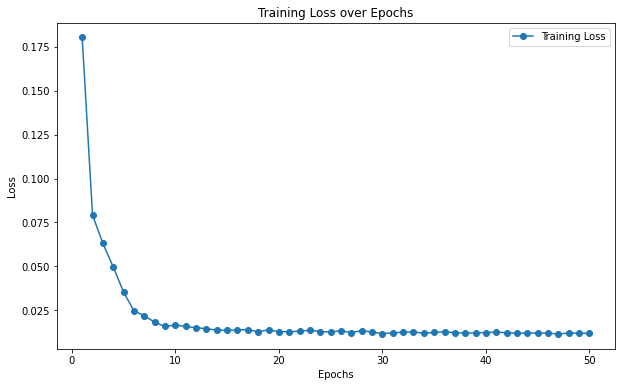

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

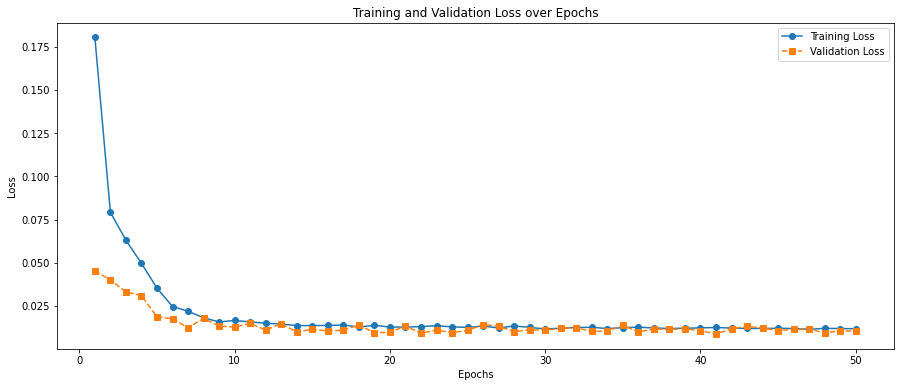

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 3s 46ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09903796963967289
MAE : 0.07497602328361884


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,647006.812500,701143.910
1,591685.437500,657891.340
2,473980.312500,432215.421
3,314758.843750,201834.787
4,162171.828125,55041.511
5,45848.472656,5387.468
6,-10725.166992,1576.813
7,43401.109375,21681.895
8,226488.218750,37772.681
9,447609.312500,239568.531


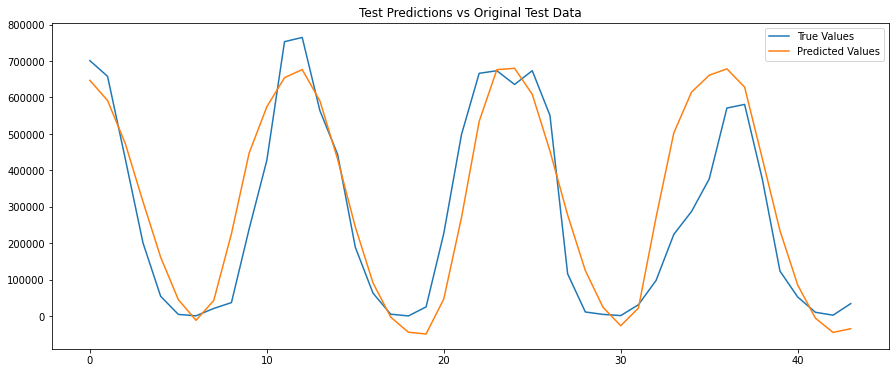

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 45ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

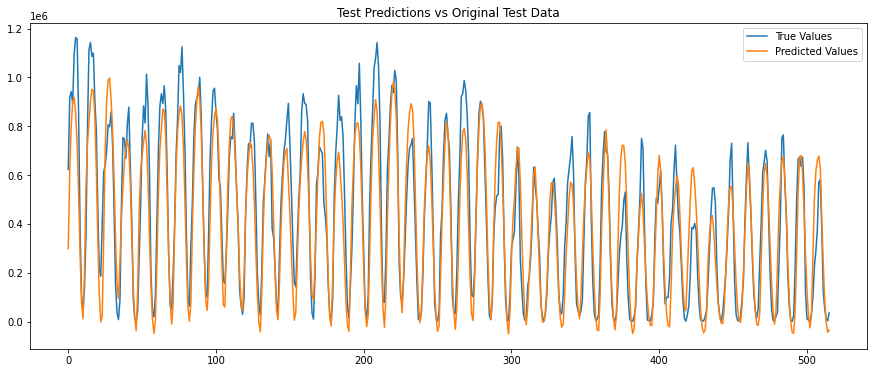

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()